**Previous book**: <a href='./04_article_similarity.ipynb'>[Article Similarity]</a>

## Part 5: Network Analysis
**NOTE**: This notebook expects <code>clustered_neighbours_df.csv</code> and <code>full_graph.gpickle</code> from the <code>04_article_similarity.ipynb</code> notebook.

In the final part of the project, we will examine a connected subgraph more closely. We will look at the basic structure including the number of nodes and edges, and examine which nodes are the most central and the different ways to measure it. We will then use these measurements as a way to classify nodes in the graph.

To end, we will also look at the strengths and limitations of the project and suggest ways that it could be improved in the future.

**Input:** <code>../data/models/full_graph.gpickle</code> and <code>../data/interrim/04_clustered_neighbours_df.csv</code>

**Output:** <code>../data/models/full_graph.gpickle</code> (updated) and <code>../data/final/completed_articles.csv</code>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pickle
import networkx as nx
from itertools import combinations

full_df = pd.read_csv("../data/interrim/04_clustered_neighbours_df.csv")

with open("../data/models/full_graph.gpickle", "rb") as f:
		G = pickle.load(f)

### Subgraphs
A **Connected Subgraph** is a subset of a larger graph where all nodes are reachable from each other, but are not connected to the rest of the graph. 

In the context of this project, a connected subgraph may represent different articles discussing the same  topic. This is similar to a cluster, but can be seen as more specific.

Find all the subgraphs in the larger graph, <code>G</code>

In [2]:
components = list(nx.connected_components(G))
sorted_components = sorted(components, key=len, reverse=True)
len(sorted_components)

462

There are 462 subgraphs that make up the graph. Considering there are only 997 nodes in total, that means the average subgraph only contains about 2.16 nodes.

This is typical of semantic networks, especially when using a high similarity threshold. Most of these subgraphs are singular nodes isolated from each other.

These nodes likely represent articles about specialist topics, or at least using very specialized vocabulary. These articles are not useful for clustering, but may offer distinct and valuable information not found elsewhere.

For network analysis, we will concentrate on one of the larger clusters:

In [3]:
subgraphs = [G.subgraph(c).copy() for c in sorted_components]
H = subgraphs[8]

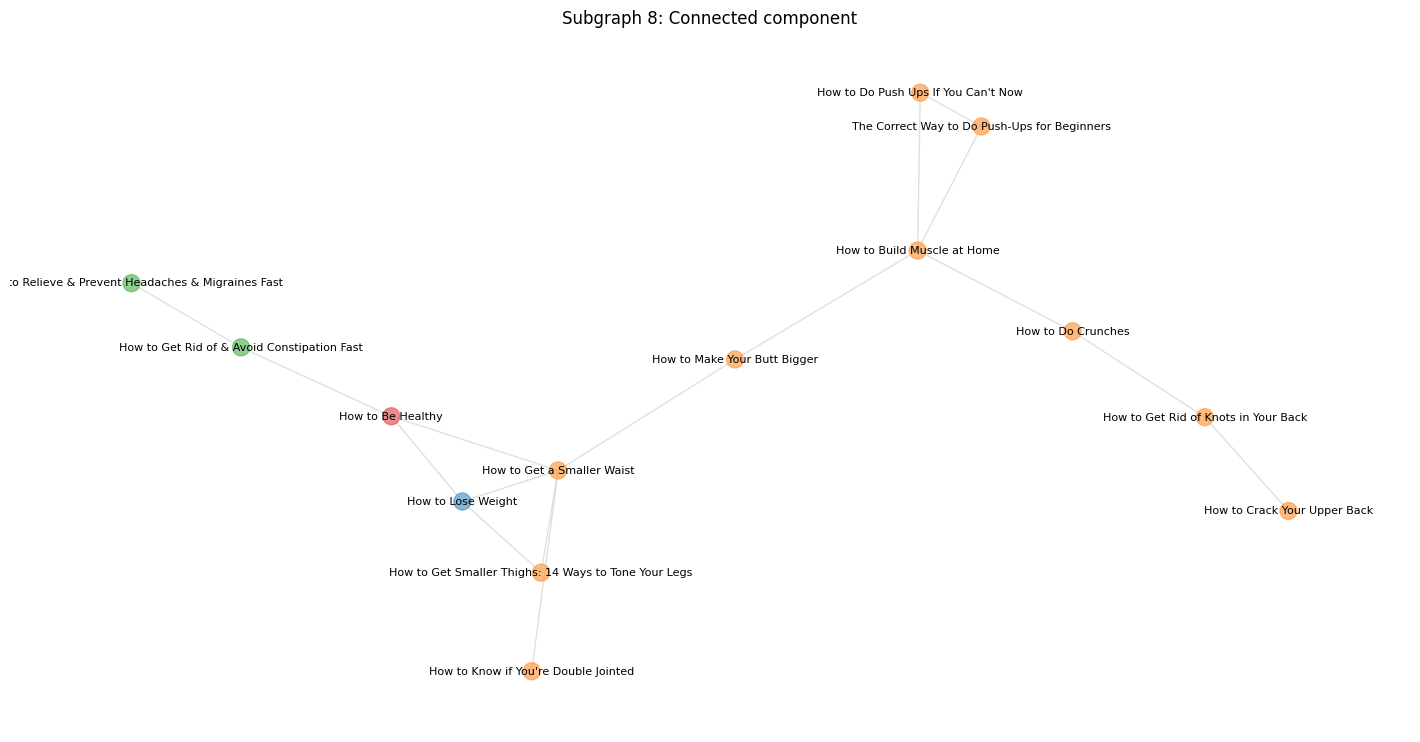

In [4]:
pos = nx.spring_layout(H, seed=22)

plt.figure(figsize=(14, 7))
node_colours = [data["color"] for _, data in H.nodes(data=True)]
node_labels = {node: data['title'] for node, data in H.nodes(data=True)}

nx.draw(
    H, pos, with_labels=False, node_size=150, labels=node_labels, node_color=node_colours, alpha=0.7, edge_color="lightgray")

nx.draw_networkx_labels(H, pos, labels=node_labels, font_size=8)


plt.title("Subgraph 8: Connected component")
plt.axis('off')
plt.show()

#### Basics
Examine the basic characteristics of the subgraph:

In [5]:
print("Number of nodes:", H.number_of_nodes())
print("Number of edges:", H.number_of_edges())
print("Density:", round(nx.density(H), 2))
print("Is connected:", nx.is_connected(H))

Number of nodes: 14
Number of edges: 16
Density: 0.18
Is connected: True


This subgraph, <code>H</code> has 14 nodes and 16 edges. As a subgraph, it also has to be connected.

**Density** measures how many edges tha graph has divided by the total possible number of connections. A value of 0.18 indicates that this graph is not well connected, and is sparse.

#### Shortest path

The **Shortest Path** represents the most direct pathway between any two given nodes which minimizes the number of edges transversed.

In [6]:
paths = []
for a1, a2 in combinations(H.nodes, 2):

    try:
        path_len = nx.shortest_path_length(H, source=a1, target=a2)
        paths.append(path_len)
    except nx.NetworkXNoPath:
        # skip unconnected nodes
        continue

np.mean(paths).round(2)

3.26

Even though the density is 0.18 and quite sprase, average distance between any two articles in this subgraph is 3.26 and can be quite quickly navigated. This reflects the layout of the graph as a relatively loose grouping with a few bridging nodes. 

#### Centrality

Which nodes are important in this subgraph? There are different ways to measure centrality.

**Degree Centrality** is essentially another measure of degree. In Networkx, the degree centrality of a node is the fraction of nodes it is connected to.

In [7]:
degree_centrality = nx.degree_centrality(H)
top_by_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

In [8]:
print("Top degree centrality")
print("----------------------")
for index, (node_id, value) in enumerate(top_by_degree):
    value = round(value, 3)
    article_name = H.nodes[node_id]["title"]
    string_literal = f"{index+1}. {article_name}"
    padded_string = string_literal.ljust(65, " ")
    print(f"{padded_string} {value}")
    

Top degree centrality
----------------------
1. How to Get a Smaller Waist                                     0.385
2. How to Build Muscle at Home                                    0.308
3. How to Be Healthy                                              0.231
4. How to Lose Weight                                             0.231
5. How to Make Your Butt Bigger                                   0.154
6. How to Get Rid of & Avoid Constipation Fast                    0.154
7. How to Do Push Ups If You Can't Now                            0.154
8. How to Get Rid of Knots in Your Back                           0.154
9. How to Do Crunches                                             0.154
10. The Correct Way to Do Push-Ups for Beginners                  0.154
11. How to Get Smaller Thighs: 14 Ways to Tone Your Legs          0.154
12. How to Relieve & Prevent Headaches & Migraines Fast           0.077
13. How to Know if You're Double Jointed                          0.077
14. How to Crack Yo

The article with the highest degree centrality is *How to Get a Smaller Waist*. This node is connected to 5 nodes out of 13 (excluding itself) or 0.385 as a proportion. This node may be redundant. A significant part of its vocabulary already appears in the neighbouring articles. However, we should investigate more before arriving at a conclusion.

**Betweenness Centrality** is how often a given node lies on the shortest path between each pair of nodes. These acts as bridges in the graph.

(The shortest path is the minimum number of edges needed to transvere to go from Node A to Node B)

In [9]:
betweenness_centrality = nx.betweenness_centrality(H)
top_by_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

In [10]:
print("Top betweenness centrality")
print("---------------------------")
for index, (node_id, value) in enumerate(top_by_betweenness):
    value = round(value, 3)
    article_name = H.nodes[node_id]["title"]
    string_literal = f"{index+1}. {article_name}"
    padded_string = string_literal.ljust(65, " ")
    print(f"{padded_string} {value}")
    

Top betweenness centrality
---------------------------
1. How to Get a Smaller Waist                                     0.622
2. How to Build Muscle at Home                                    0.59
3. How to Make Your Butt Bigger                                   0.538
4. How to Be Healthy                                              0.282
5. How to Do Crunches                                             0.282
6. How to Get Rid of & Avoid Constipation Fast                    0.154
7. How to Get Rid of Knots in Your Back                           0.154
8. How to Lose Weight                                             0.019
9. How to Relieve & Prevent Headaches & Migraines Fast            0.0
10. How to Know if You're Double Jointed                          0.0
11. How to Do Push Ups If You Can't Now                           0.0
12. The Correct Way to Do Push-Ups for Beginners                  0.0
13. How to Crack Your Upper Back                                  0.0
14. How to Get Small

In this subgraph, *How to Get a Smaller Waist* also has the highest betweenness centrality. From the graph, this node also connects 3 different topics (Red - "Emotions and Social", Blue - "Gaming and Intellectual" and "Yellow - Sports and Physical" which it is a part of). This article seems to bridge the gap between different health topics: Building muscle, losing weight and being healthy. Removing this node would split the subgraph into two connected components.

*How to Lose Weight*, on the other hand, has relatively low betweenness centrality (ranked number 8) compared ot degree centrality (ranked number 4). This article likely repeats advice found in the neighbouring articles without bridging to topics found in other subgraphs. Removing this node would not significantly affect the connectedness of the overall subgraph (and as a node from a different cluster, may also improve clustering).

### Node classification

We can divide the the articles into 4 categories based on their degree centrality and betweenness centrality.

#### High Degree and High Betweenness (Hub)

Articles with **high degree centrality** and **high betweenness centrality** do not just share vocabulary, they bridge the gap between many distinct articles. These articles are likely to be comprehensive guides that cover a lot of areas, or a hub that unites various topics into one guide. These articles are likely very important and could have connections with articles in other clusters. These articles will be referred to as *Hub* articles.

#### High Degree and Low Betweenness (Redundant)

Conversely, articles with **high degree centrality** and **low betweenness centrality** share a lot of vocabulary with other articles, but do not bring together different groups. These articles likely overlap significantly with other articles and tend to be firmly placed in their own clusters. These articles may be *redundant* and may be marked to be rewritten or pruned.

#### Low Degree and High Betweenness (Bridge)

Articles that have **high betweenness centrality** and **low degree centrality** have fewer direct connections, but lie on paths between otherwise disconnected subgraphs. These articles act as semantic connectors that could represent interdisciplinary articles. These articles are important for navigating through the encyclopedia. These articles will be referred to as **Bridge** articles.

#### Low Degree and Low Betweenness (Peripheral)
The last combination is **low degree centrality** and **low betweenness centrality**. These articles have few or no connections to other articles and have little influence over the structure of the graph. They are around the edge or *peripheral*. These articles likely contain niche information about less common topics. These articles are useful for their specialist knowledge, but may be expanded to become more general.

With the terms defined, we need to measure the degree centrality and the betweenness centrality:

In [11]:
degree_centrality_total = nx.degree_centrality(G)
betweenness_centrality_total = nx.betweenness_centrality(G)

In [12]:
degree_list = [degree_centrality_total[n] for n in G.nodes]
betweenness_list = [betweenness_centrality_total[n] for n in G.nodes]

Create a dataframe containing the centrality information:

In [13]:
centrality_df = pd.DataFrame({"Article_Id": list(G.nodes()), "Degree": degree_list, "Betweenness": betweenness_list})
centrality_df.head()

,Article_Id,Degree,Betweenness
0,1,0.000000,0.000000
1,2,0.005020,0.000066
2,3,0.004016,0.000004
3,4,0.007028,0.001309
4,5,0.003012,0.000000


In [14]:
for index, node in enumerate(G.nodes()):
    G.nodes[node]["global_degree"] = centrality_df["Degree"].iloc[index]
    G.nodes[node]["global_betweenness"] = centrality_df["Betweenness"].iloc[index]

We can now classify the different articles using the criteria above. We will take the 

In [15]:
degree_thresh = centrality_df["Degree"].quantile(0.75)
between_thresh = centrality_df["Betweenness"].quantile(0.75)

def classify_article(article):
    if article["Degree"] >= degree_thresh and article["Betweenness"] >= between_thresh:
        return "Hub"
    elif article["Degree"] >= degree_thresh and article["Betweenness"] < between_thresh:
        return "Redundant"
    elif article["Degree"] < degree_thresh and article["Betweenness"] >= between_thresh:
        return "Bridge"
    else:
        return "Peripheral"

In [16]:
centrality_df["Category"] = centrality_df.apply(classify_article, axis=1)

Add the centralities as node attributes:

In [17]:
for index, node in enumerate(G.nodes()):
    G.nodes[node]["global_degree"] = float(centrality_df["Degree"].iloc[index])
    G.nodes[node]["global_betweenness"] = float(centrality_df["Betweenness"].iloc[index])
    G.nodes[node]["category"] = centrality_df["Category"].iloc[index]

Check the node attributes:

In [18]:
G.nodes[3]

{'title': 'How to Play Poker',
 'cluster': 0,
 'color': '#5799C6',
 'views': 7598092,
 'topic': 'Gaming and Intellectual',
 'popularity': 'Very High',
 'global_degree': 0.004016064257028112,
 'global_betweenness': 3.94014440148726e-06,
 'category': 'Redundant'}

Join to centrality dataframe to the main dataframe:

In [19]:
full_df = full_df.merge(centrality_df, how="left", on="Article_Id")

We can now compare how the different category of articles are spread out across the clusters:

In [20]:
cluster_names = full_df[["Cluster", "Topic"]].drop_duplicates()
category_matrix = pd.crosstab(full_df["Cluster"], full_df["Category"]).reset_index()
category_matrix = cluster_names.merge(category_matrix, on="Cluster")
category_matrix.set_index(["Cluster", "Topic"]).sort_values(by="Cluster")

,,Bridge,Hub,Peripheral,Redundant
Cluster,Topic,,,,
0,Gaming and Intellectual,6,14,222,12
1,Sports and Physical,3,9,46,10
2,Hygiene and Home,21,33,178,9
3,Emotions and Social,13,53,101,9
4,Haircare,1,8,5,24
5,Technology,19,44,67,5
6,Crafts,1,26,45,13


In [21]:
full_df["Cluster"].value_counts()

Cluster
0    254
2    241
3    176
5    135
6     85
1     68
4     38
Name: count, dtype: int64

From the table above, we can see that the majority of articles are peripheral. This makes sense by the structure of the topic map and how each category was defined.

Other insights:

<ul>
    <li>The most loosely define cluster, Gaming and Technical, has the highest proportion of Peripheral articles. This is consistent with our previous findingings.</li>
    <li>The most well defined cluster, Haircare, has the highest proportion of Redundant articles. This is also consistent.</li>
    <li>Emotions and Social, and Computers both have a large proportion of high value Hub articles.</li>
    <li>Computers also has the highest proportion of Bridge articles.</li>
</ul>

Based on our classification, we would expect that Hub articles would be the most popular, and Redundant may be the least popular. We can examine the articles by views:

In [22]:
full_df.groupby("Category")["Views"].agg(["mean", "median", "std", "count"]).round()

,mean,median,std,count
Category,,,,
Bridge,1884288.0,757726.0,2553469.0,64
Hub,3085778.0,1526600.0,5063828.0,187
Peripheral,1900358.0,1098048.0,2600065.0,664
Redundant,1786770.0,1268308.0,1614826.0,82


Plot boxplot because the standard deviations are high:

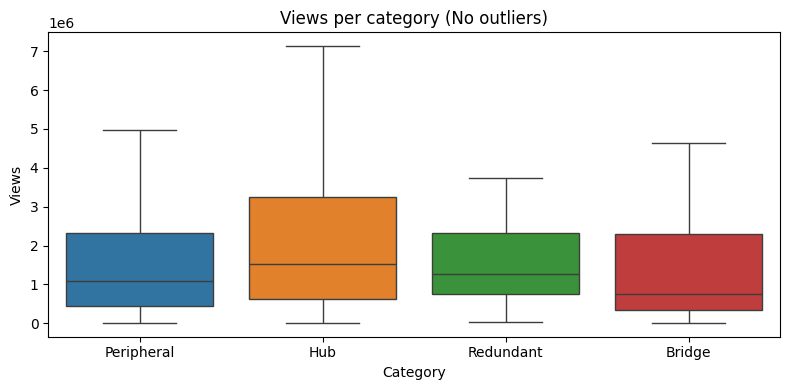

In [23]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=full_df, x="Category", y="Views", hue="Category", showfliers=False, legend=False)

plt.title('Views per category (No outliers)')
plt.xlabel("Category")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

From the chart above, we can see the most popular category of articles is the Hub category. Redundant article are not the least popular, but they tend to get the fewest views looking at the upper and lower quartiles.

Examine crosstab with popularities and category type for nuanced look:

In [24]:
popularity_order = ["Low", "Medium", "High", "Very High"]
full_df["Popularity"] = pd.Categorical(full_df["Popularity"], categories=popularity_order, ordered=True)
pop_cat_matrix = pd.crosstab(full_df["Popularity"], full_df["Category"])
pop_cat_matrix

Category,Bridge,Hub,Peripheral,Redundant
Popularity,,,,
Low,23,39,176,12
Medium,15,38,170,26
High,10,49,164,26
Very High,16,61,154,18


Examing Category with Popularity adds another dimension, and opens up new ways to categorize the nodes. For example, Redundant nodes with low popularity can be considered as nodes to be pruned, or a peripheral node with high popularity is classified as niche favourite, not related to other articles but popular anyway.



Export the final dataframe as CSV and Graph:

In [25]:
full_df.to_csv("../data/final/completed_articles.csv", index=False)
with open("../data/models/full_graph.gpickle", "wb") as f:
    pickle.dump(G, f)

### Summary

In the final part of the project, we

<ul>
    <li>We examined a subgraph more closely, calculating its density, average shortest path and measures of centrality.</li>
    <li>Defined four categories of nodes: Hubs, Bridges, Peripheral, Redundant.
    <li>Collected centrality measurements from the entire graph and classified nodes based on their values.</li>
    <li>Investigated how category and cluster interact, and the distribution of views for each category.</li>
</ul>


### Findings and Limitations

#### Findings

In this project, we successfully clustered wikiHow articles into broad meaningful topics with k-means clustering of TF-IDF reduced vectors. We then built a semantic topic map which revealed topic relations both within and between clusters.

Using a connected subgraph of the graph, we explored a semantic neighbourhood focused on 14 different articles. Using this as an example, we identified 4 different types of node that all display different behaviours such as hubs and bridges. 

This demonstrates how clustering and network analysis can help balance corpus coverage, identify specialist topics, or identify gaps in a semantic topic map.

#### Limitations

While it achieved its goal, there are some limitations with this project. The original text was not adequately cleaned before being processed leaving some unwanted elements in the topic such as HTML elements. This does not appear to have affected the results, but it is best practice to remove these elements before. Furthermore, the TF-IDF approach treats words as distinct tokens and does not take into account semantic similarity such as synonyms. More advanced techniques using word embeddings are likely to improve the results.

There are also abundant isolated nodes and peripheral articles affecting cluster cohesion. k-means clustering provides a flat topic structure. Agglutinative clustering may improve the results by providing a natural structure containing topics and sub-topics.

#### Next stages

There is also an [interactive dashboard](http://wikihow-network.streamlit.app) that can be used to explore the topic map.

### Navigation
**Previous book**: <a href='./04_article_similarity.ipynb'>[Article Similarity]</a>

**Next book**: None